In [1]:
import numpy as np
from numpy import mean
from numpy import std
from numpy import dstack
from numpy import array

import pandas as pd
from pandas import read_csv
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from tensorflow.keras.layers import Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Input, Dropout, Flatten, BatchNormalization
from tensorflow.keras.layers import concatenate, Dropout
from keras.utils import to_categorical
from tensorflow.keras import optimizers
import seaborn as sns

In [2]:
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(),
                                  columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1]) 
                                                                                         if x[1] >0 else x[0] ,  axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

def get_human_dataset( ):
    
    # 각 데이터 파일들은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당.
    feature_name_df = pd.read_csv('C:/Users/khw/2023DeepLearning/human+activity+recognition+using+smartphones/UCI HAR Dataset/UCI HAR Dataset/features.txt',sep='\s+',
                        header=None,names=['column_index','column_name'])
    
    # 중복된 피처명을 수정하는 get_new_feature_name_df()를 이용, 신규 피처명 DataFrame생성. 
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    
    # DataFrame에 피처명을 컬럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    
    # 학습 피처 데이터 셋과 테스트 피처 데이터을 DataFrame으로 로딩. 컬럼명은 feature_name 적용
    X_train = pd.read_csv('C:/Users/khw/2023DeepLearning/human+activity+recognition+using+smartphones/UCI HAR Dataset/UCI HAR Dataset/train/X_train.txt',sep='\s+', names=feature_name )
    X_test = pd.read_csv('C:/Users/khw/2023DeepLearning/human+activity+recognition+using+smartphones/UCI HAR Dataset/UCI HAR Dataset/test/X_test.txt',sep='\s+', names=feature_name)
    
    # 학습 레이블과 테스트 레이블 데이터을 DataFrame으로 로딩하고 컬럼명은 action으로 부여
    y_train = pd.read_csv('C:/Users/khw/2023DeepLearning/human+activity+recognition+using+smartphones/UCI HAR Dataset/UCI HAR Dataset/train/y_train.txt',sep='\s+',header=None,names=['action'])
    y_test = pd.read_csv('C:/Users/khw/2023DeepLearning/human+activity+recognition+using+smartphones/UCI HAR Dataset/UCI HAR Dataset/test/y_test.txt',sep='\s+',header=None,names=['action'])
    
    print("trainX shape: ",X_train.shape)
    print("trainy shape: ", y_train.shape)
    print("testX shape: ", X_test.shape)
    print("testy shape: ", y_test.shape)
    # 로드된 학습/테스트용 DataFrame을 모두 반환 
    return X_train, X_test, y_train, y_test

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# 결정 트리에서 사용한 get_human_dataset( )을 이용해 학습/테스트용 DataFrame 반환
X_train, X_test, y_train, y_test = get_human_dataset()

print("## 학습 피처 데이터 정보 ##")
print(X_train.info())

trainX shape:  (7352, 561)
trainy shape:  (7352, 1)
testX shape:  (2947, 561)
testy shape:  (2947, 1)
## 학습 피처 데이터 정보 ##
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 561 entries, tBodyAcc-mean()-X to angle(Z,gravityMean)
dtypes: float64(561)
memory usage: 31.5 MB
None


In [4]:
# Reformat the training data into sequence samples
# Source: https://machinelearningmastery.com/how-to-develop-convolutional-neural-network-models-for-time-series-forecasting/

def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [5]:
y_train_array = np.array(y_train)
train_set = np.c_[X_train, y_train_array]

y_test_array = np.array(y_test)
test_set = np.c_[X_test, y_test_array]

X_train, y_train = split_sequences(train_set, 25)
print(X_train.shape, y_train.shape)

X_test, y_test = split_sequences(test_set, 25)
print(X_test.shape, y_test.shape)

(7328, 25, 561) (7328,)
(2923, 25, 561) (2923,)


In [6]:
print(X_train.shape, y_train.shape)

(7328, 25, 561) (7328,)


In [7]:
# Convert output variables to categorical for CNN
y_train = to_categorical(y_train)
print(y_train.shape)

y_test = to_categorical(y_test)
print(y_test.shape)

(7328, 7)
(2923, 7)


In [8]:
# Produce variables for CNN input/output shape
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
print(n_timesteps, n_features, n_outputs)

25 561 7


In [9]:
## set number of epochs and batch size
batch_size = 64
validation_split = 0.2

In [10]:
model = Sequential()
model.add(LSTM(100, input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))

In [11]:
from keras.optimizers import Adam


model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.01), metrics=['accuracy'])

In [12]:
# fit network
train_epochs = 10
history = model.fit(X_train, y_train, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_split=validation_split, shuffle=True)

Epoch 1/10
92/92 [==============================] - 11s 84ms/step - loss: 0.6885 - accuracy: 0.7368 - val_loss: 0.2270 - val_accuracy: 0.9093
Epoch 2/10
92/92 [==============================] - 6s 71ms/step - loss: 0.2279 - accuracy: 0.9159 - val_loss: 0.1250 - val_accuracy: 0.9332
Epoch 3/10
92/92 [==============================] - 7s 74ms/step - loss: 0.1320 - accuracy: 0.9514 - val_loss: 0.0673 - val_accuracy: 0.9809
Epoch 4/10
92/92 [==============================] - 7s 72ms/step - loss: 0.0949 - accuracy: 0.9654 - val_loss: 0.0834 - val_accuracy: 0.9679
Epoch 5/10
92/92 [==============================] - 7s 72ms/step - loss: 0.0705 - accuracy: 0.9771 - val_loss: 0.0896 - val_accuracy: 0.9693
Epoch 6/10
92/92 [==============================] - 7s 75ms/step - loss: 0.0581 - accuracy: 0.9816 - val_loss: 0.0683 - val_accuracy: 0.9789
Epoch 7/10
92/92 [==============================] - 7s 74ms/step - loss: 0.0486 - accuracy: 0.9840 - val_loss: 0.0928 - val_accuracy: 0.9659
Epoch 8/10
9

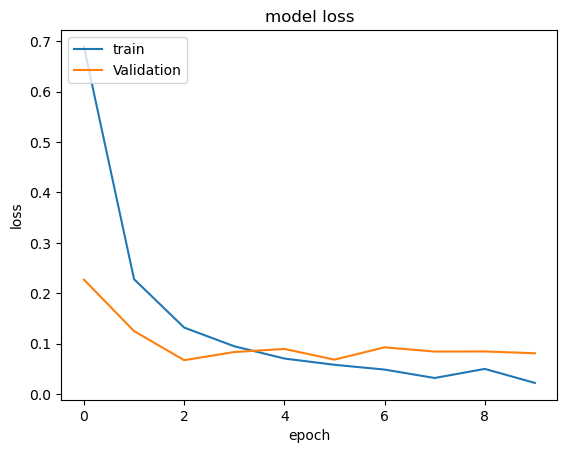

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

In [15]:
# evaluate model
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
print("Accuracy of the LSTM model", test_accuracy)
# Get the predictions for the test set
predictions = model.predict(X_test)

Accuracy of the LSTM model 0.9695518016815186
92/92 [==============================] - 3s 26ms/step


In [16]:
predictions

array([[3.05522434e-07, 3.79649407e-07, 6.28158614e-06, ...,
        5.46712941e-03, 9.94524717e-01, 5.68427993e-07],
       [1.83403870e-07, 1.58853808e-07, 3.95329425e-06, ...,
        3.36205354e-03, 9.96632993e-01, 4.09326702e-07],
       [1.17219045e-07, 7.58845218e-08, 2.62302206e-06, ...,
        2.39958637e-03, 9.97597158e-01, 2.55289223e-07],
       ...,
       [3.66548556e-06, 3.81590471e-05, 9.99101400e-01, ...,
        3.40780571e-06, 5.46352181e-04, 1.30937065e-06],
       [9.17921079e-06, 4.42874043e-05, 9.96103764e-01, ...,
        2.75725961e-05, 3.38414847e-03, 1.56701776e-06],
       [1.20552750e-05, 8.73648605e-05, 9.94983435e-01, ...,
        2.87048606e-05, 4.30066697e-03, 1.92889524e-06]], dtype=float32)

In [17]:
def display_results(testy,predictions,classNames):
    y_test=np.argmax(testy, axis=1)
    y_scores=np.argmax(predictions, axis=1)
    classes = len(classNames)
    cm = confusion_matrix(y_test, y_scores)
    print("**** Confusion Matrix ****")
    print(cm)
    print("**** Classification Report ****")
    print(classification_report(y_test, y_scores, target_names=classNames))
    con = np.zeros((classes,classes))
    for x in range(classes):
        for y in range(classes):
            con[x,y] = cm[x,y] #/np.sum(cm[x,:])

    plt.figure(figsize=(10,8))
    df = sns.heatmap(con, annot=True, fmt='g', cmap='Blues',xticklabels= classNames , yticklabels= classNames)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

**** Confusion Matrix ****
[[484   0  12   0   0   0]
 [  0 465   6   0   0   0]
 [  1  26 393   0   0   0]
 [  0   2   0 456  31   2]
 [  0   1   0   2 505   0]
 [  0   0   0   1   5 531]]
**** Classification Report ****
              precision    recall  f1-score   support

           1       1.00      0.98      0.99       496
           2       0.94      0.99      0.96       471
           3       0.96      0.94      0.95       420
           4       0.99      0.93      0.96       491
           5       0.93      0.99      0.96       508
           6       1.00      0.99      0.99       537

    accuracy                           0.97      2923
   macro avg       0.97      0.97      0.97      2923
weighted avg       0.97      0.97      0.97      2923



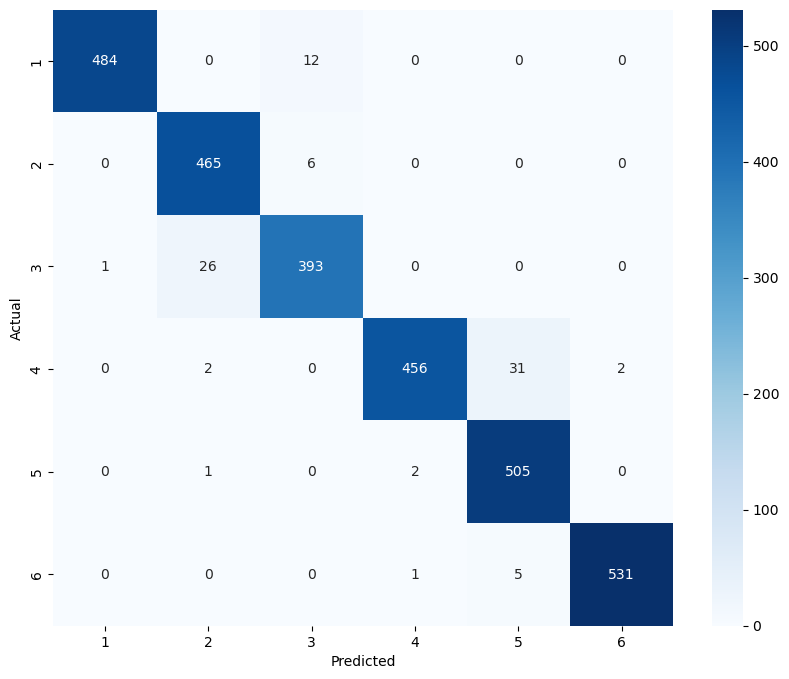

In [19]:
from sklearn.metrics import confusion_matrix, classification_report
classNames=["1","2","3","4","5","6"]
display_results(y_test,predictions,classNames)

In [20]:
# Produce variables for CNN input/output shape
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
print(n_timesteps, n_features, n_outputs)

25 561 7


In [21]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=7, activation='relu', padding='same', input_shape=(n_timesteps, n_features)))
model.add(MaxPooling1D(2))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same', input_shape=(n_timesteps, n_features)))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same', input_shape=(n_timesteps, n_features)))
model.add(MaxPooling1D(2))
model.add(Conv1D(filters=256, kernel_size=3, activation='relu', padding='same', input_shape=(n_timesteps, n_features)))
model.add(Conv1D(filters=256, kernel_size=3, activation='relu', padding='same', input_shape=(n_timesteps, n_features)))
model.add(MaxPooling1D(2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))


In [22]:
from keras.optimizers import Adam


model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.01), metrics=['accuracy'])

In [23]:
# fit network
train_epochs = 20
history = model.fit(X_train, y_train, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_split=validation_split, shuffle=True)

Epoch 1/20
92/92 [==============================] - 23s 202ms/step - loss: 1.2781 - accuracy: 0.4603 - val_loss: 0.5797 - val_accuracy: 0.7538
Epoch 2/20
92/92 [==============================] - 17s 182ms/step - loss: 0.5453 - accuracy: 0.7813 - val_loss: 0.3392 - val_accuracy: 0.8718
Epoch 3/20
92/92 [==============================] - 10s 108ms/step - loss: 0.3401 - accuracy: 0.8751 - val_loss: 0.4356 - val_accuracy: 0.8424
Epoch 4/20
92/92 [==============================] - 8s 86ms/step - loss: 0.2573 - accuracy: 0.9111 - val_loss: 0.2320 - val_accuracy: 0.9222
Epoch 5/20
92/92 [==============================] - 7s 74ms/step - loss: 0.1862 - accuracy: 0.9386 - val_loss: 0.2554 - val_accuracy: 0.9038
Epoch 6/20
92/92 [==============================] - 6s 70ms/step - loss: 0.1282 - accuracy: 0.9643 - val_loss: 0.1585 - val_accuracy: 0.9393
Epoch 7/20
92/92 [==============================] - 6s 71ms/step - loss: 0.1248 - accuracy: 0.9635 - val_loss: 0.1300 - val_accuracy: 0.9563
Epoch 8

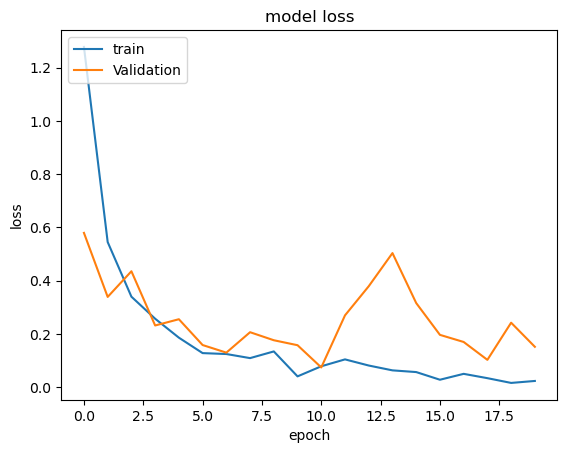

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

In [25]:
# evaluate model
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
print("Accuracy of the CNN model", test_accuracy)
predictions=model.predict(X_test)

Accuracy of the CNN model 0.9716045260429382
92/92 [==============================] - 4s 35ms/step


**** Confusion Matrix ****
[[495   0   1   0   0   0]
 [  2 464   5   0   0   0]
 [  8  20 392   0   0   0]
 [  0   0   0 459  30   2]
 [  0   1   0   4 503   0]
 [  0   0   0  10   0 527]]
**** Classification Report ****
              precision    recall  f1-score   support

           1       0.98      1.00      0.99       496
           2       0.96      0.99      0.97       471
           3       0.98      0.93      0.96       420
           4       0.97      0.93      0.95       491
           5       0.94      0.99      0.97       508
           6       1.00      0.98      0.99       537

    accuracy                           0.97      2923
   macro avg       0.97      0.97      0.97      2923
weighted avg       0.97      0.97      0.97      2923



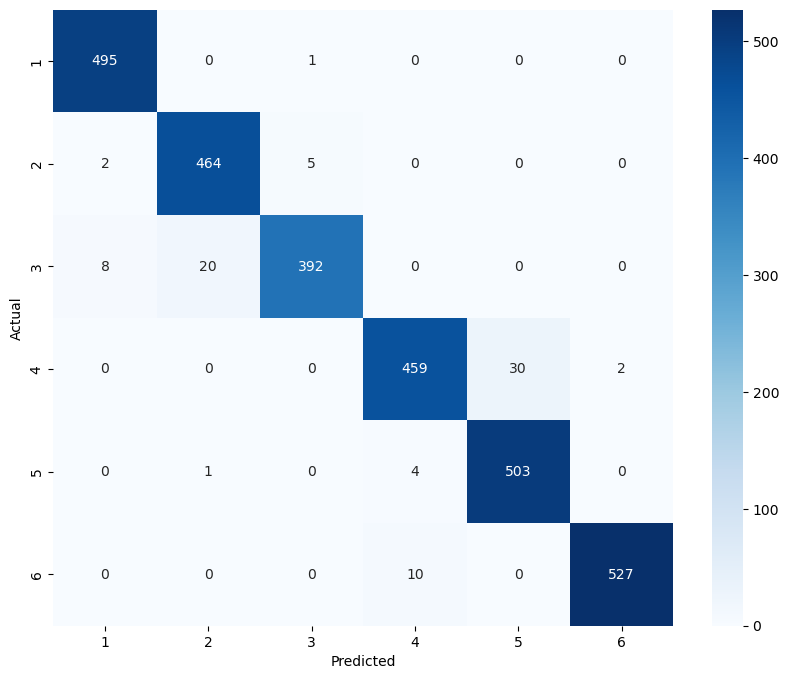

In [27]:
display_results(y_test,predictions,classNames)